In [5]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
figsize(10, 10)

# INPUT PIPELINES

In [9]:
from dlinputs import gopen, utils

# TensorFlow / Large Scale Google DL Infrastructure

- Google FS / HDFS - large scale distributed storage
- tf.Record - sequential record storage
- tf.Example - data encoding

# Problems

- scalable infastructure not open source
- uncommon protocols 
- poor tool support
- components designed for different purposes
- tied to TensorFlow

# Good Aspects of GFS + tf.Record + tf.Example

- sequential I/O (= fast)
- distributed file service

Want to recreate these aspects but...

- common protocols, data formats
- platform / framework agnostic
- don't reinvent the wheel

# DLINPUTS

# dlinputs

A library for making I/O for large scale DL training efficient and simple.

- written in pure Python
- can be used with any DL framework
- scales up to very large datasets
- can be used on streaming data
- supports map-reduce and distributed data augmentation
- data storage format is open and well supported

__key__ 'A001BIN'
__source__ <type 'NoneType'> None
framed.png float32 (3300, 2592)
lines.png float32 (3300, 2592)


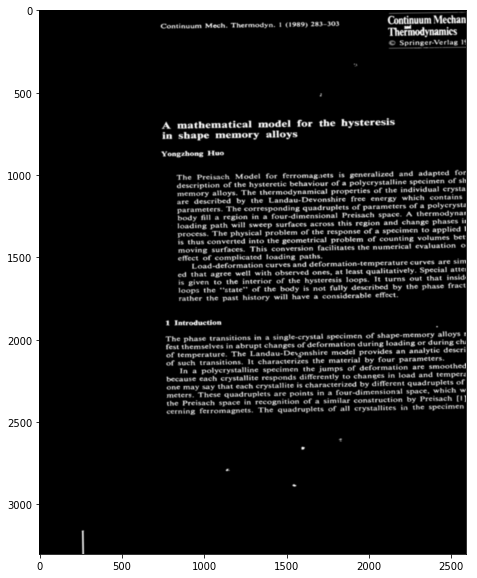

In [26]:
data = gopen.sharditerator("https://storage.googleapis.com/tmb-ocr/uw3-framed-lines-degraded-@010.tgz")
for sample in data:
    # ... training here ...
    utils.print_sample(sample)
    imshow(sample["framed.png"])
    break

# data is stored in tar files

- standard format, widely supported
- can usually create directly from a file system using tar
- can untar to recreate original on-disk dataset
- natural format for compressed data
- natural sequential record format
- alternative to `tf.Record`

# tar files with simple conventions

- files that belong to the same sample need to be adjacent in the tar file
- the basename determines the sample, the extension the sample key (configurable)
- standard file name extensions (`.png`, `.json`, ...) are recognized and decoded (configurable)

In [21]:
!curl -s -r 0-8000000 https://storage.googleapis.com/tmb-ocr/uw3-framed-lines-degraded-000.tgz | tar -ztvf - 2>&1 | sed 10q

-rw-rw-rw- bigdata/bigdata 837980 2018-03-30 04:09 A001BIN.framed.png
-rw-rw-rw- bigdata/bigdata  98260 2018-03-30 04:09 A001BIN.lines.png
-rw-rw-rw- bigdata/bigdata 360751 2018-03-30 04:09 A002BIN.framed.png
-rw-rw-rw- bigdata/bigdata  10041 2018-03-30 04:09 A002BIN.lines.png
-rw-rw-rw- bigdata/bigdata 720773 2018-03-30 04:10 A003BIN.framed.png
-rw-rw-rw- bigdata/bigdata  95208 2018-03-30 04:10 A003BIN.lines.png
-rw-rw-rw- bigdata/bigdata 945160 2018-03-30 04:10 A004BIN.framed.png
-rw-rw-rw- bigdata/bigdata 105373 2018-03-30 04:10 A004BIN.lines.png
-rw-rw-rw- bigdata/bigdata 730622 2018-03-30 04:10 A005BIN.framed.png
-rw-rw-rw- bigdata/bigdata  92424 2018-03-30 04:10 A005BIN.lines.png


# access protocol = HTTP

- very widely support protocol
- lots of high performance servers, caches, proxies
- HTTP redirect supports large-scale load balancing
- can train directly from S3, Google Cloud, Ceph, ...
- no need for file system drivers for Docker/Kubernetes

# sharding

- sufficient I/O throughput requires
  - breaking up big datasets into smaller pieces (shards)
  - parallel I/O between shards
  - sequential I/O within shards
- shards also allow shuffling
- sequential reads: 200 MB/s, random acces: 20 MB/s


# shard syntax

http://server/bucket/path-@001000.tgz
    
expands to...

http://server/bucket/path-000000.tgz ... http://server/bucket/path-000999.tgz

# PyTorch shard iterator

    gopen.sharditerator("https://storage.googleapis.com/tmb-ocr/uw3-framed-lines-degraded-@010.tgz")
    
- enumerates all 10 shards
- shuffles them
- opens one or more in parallel
- follows redirects in case there is a load balancer
- reads sequentially through them
- decodes the file contents based on file name extensions

# MAP REDUCE JOBS

# Map Reduce Jobs

- Often, we need to process large numbers of files.
- When using sharded tar files, this is easy:
  - write a simple shard-to-shard mapper
  - put all the shard processing into Kubernetes or Slurm jobs
  - "reduce" is handled by sorting jobs
- used for...
  - inference
  - test set error measurement
  - preprocessing
  - data augmentation
  - randomization

Simple mapping job; this is all you ever really have to worry about:
    
    parser = ArgumentParser(...)
    ...
    args = parser.parse_args()
    
    source = gopen.sharditerator_once(args.input)
    sink = gopen.ShardWriter(args.output)
    for sample in source:
        processed = ...
        sink.write(sample)

# FILTERS AND PIPELINES

# Common Operations on Streams of Data

    pipeline = filters.compose(
        filters.shuffle(1000),
        filters.ren(image="png", target="lines.png"),
        filters.map(image=lambda x: 1-x),
        filters.batched(64)
    )
    


# Common Operations on Streams of Data

- look like UNIX pipelines
- can be composed with `filters.compose`
- really are simply Python iterators

This:

    f = filters.map(image=lambda x: 1-x)
    
is just this:

    def f(data):
        for sample in data:
            result = dict(sample)
            sample["image"] = 1 - sample["image"]
        

# Stream Operations Available

- merging, concatenating, shuffling
- grepping, duplicate removal, selecting
- field renaming
- field mapping
- patching
- debugging, printing
- encoding, decoding
- batching, batch-by-size
- data augmentation

# Dataset Patching and Versioning

- big datasets evolve
- you can't store new copies, so you store patches
- the library lets you apply patches to datasets on the fly


    patched = filters.source(
        gopen.open_source("gs://nvtrain/dataset-@0100000.tgz"),
        filters.patch("gs://nvpatch/2017-06-@0000010.tgz"),
        filters.patch("gs://nvpatch/2017-09-@0000003.tgz"),
        filters.patch("gs://nvpatch/2018-01-@0000007.tgz")
    )

# LARGE SCALE TRAINING

# Large Scale, Multi-Server Training

<img src="figs/distributed.jpg" width=800>


# Large Scale Distributed Training

- commonly 16-256 GPUs training from the same dataset
- 200-1000 GB/s input data rate per GPU
- disk : GPU ratio of 2:1 to 10:1
- CPU node : GPU node ratio of 2:1
- on average, each disk only used by at most one GPU
- data is cached from archival storage to dedicated disks
- all protocols are HTTP (WebDav for management operations)

# DFC Project

DFC -- NVIDIA open source project to support large scale training like this

You don't have to be concerned with the backend, just point to a web server and the rest is automatic.